In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, zero_one_loss, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from xgboost import XGBClassifier
from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from collections import Counter

In [2]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional\bank-additional.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
print(df.shape)

(4119, 20)


In [3]:
#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [4]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)

In [5]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(train_features)
X_test_ss = ss.transform(test_features)

# niet genormaliseerd
# X_train_ss = train_features
# X_test_ss = test_features

# KMeans

In [6]:
kmeans = KMeans(
    init="random", # initialisation technique
    n_clusters=10, # "k" in k-means
    n_init=10, # nr of initialisations to perform
    max_iter=300, # max nr iterations for each initialisation
    random_state=23
)

In [7]:
#statistics from the initialization run with the lowest SSE are available as attributes of kmeans after calling .fit():
kmeans.fit(X_train_ss)

KMeans(init='random', n_clusters=10, random_state=23)

In [8]:
# The lowest SSE value
print(kmeans.inertia_)

# Final locations of the centroid
# print(kmeans.cluster_centers_)

# The number of iterations required to converge
print(kmeans.n_iter_)

126630.3072163448
12


### Choosing the Appropriate Number of Clusters

#### Elbow method (look for elbow)

In [9]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 23,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 30):
    kmeans2 = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans2.fit(X_train_ss)
    sse.append(kmeans2.inertia_)

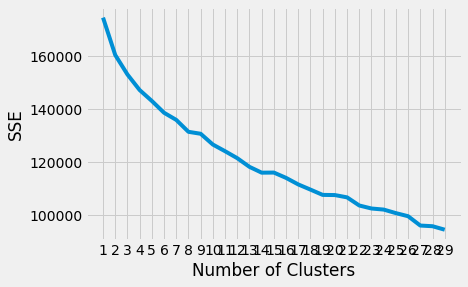

In [10]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30), sse)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [11]:
# finding elbow (reasonable trade-off between error and number of clusters)
kl = KneeLocator(
    range(1, 30), sse, curve="convex", direction="decreasing"
)

print("Elbow: " + str(kl.elbow))

Elbow: 13


#### Silhouette method (look for high silhoutte coefficient)

In [14]:
# measure of cluster cohesion and separation
# quantifies how well a data point fits into its assigned cluster based on:
     # how close the data point is to other points in the cluster
     # how far away the data point is from points in other clusters
        
# holds the silhouette coefficients for each k
silhouette_coefficients = []

# start at 2 clusters for silhouette coefficient
for k in range(2, 30):
    kmeans3 = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans3.fit(X_train_ss)
    score = silhouette_score(X_train_ss, kmeans3.labels_)
    silhouette_coefficients.append(score)

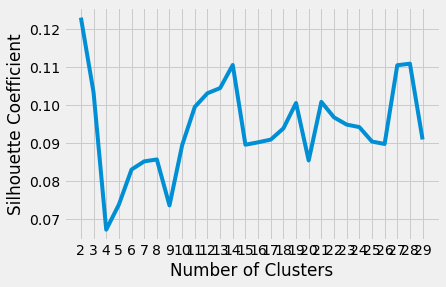

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), silhouette_coefficients)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()